In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [52]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):

    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid
def create_tilings(low, high, tiling_specs):

    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]

def discretize(sample, grid):
    
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension

def tile_encode(sample, tilings, flatten=False):


    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample

In [53]:
class QTable:

    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)
class TiledQTable:
    
    def __init__(self, low, high, tiling_specs, action_size):

        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    def get(self, state, action):

        encoded_state = tile_encode(state, self.tilings)
        
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            value += q_table.q_table[tuple(idx + (action,))]
        value /= len(self.q_tables)
        return value
    def update(self, state, action, value, alpha=0.1):

        encoded_state = tile_encode(state, self.tilings)
        for idx, q_table in zip(encoded_state, self.q_tables):
            value_ = q_table.q_table[tuple(idx + (action,))]  # current value
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_


In [9]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tq, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=0):
        
        # Environment info
        self.env = env
        self.tq = tq 
        self.state_sizes = tq.state_sizes           
        self.action_size = self.env.action_space.n  
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space sizes:", self.state_sizes)
        print("Action space size:", self.action_size)
        
        # Hyperparameters 
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate   
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
    def act(self, state, reward=None, done=None, mode='train'):
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        # Pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            action = greedy_action
        else:

            value = reward + self.gamma * max(Q_s)
            self.tq.update(self.last_state, self.last_action, value, self.alpha)

            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                action = greedy_action

        self.last_state = state
        self.last_action = action
        return action

In [2]:
# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [ 1.     1.     1.     1.    12.566 28.274]
Action space: Discrete(3)


In [10]:
n_bins = 5
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

tiling_specs = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]

tq = TiledQTable(env.observation_space.low, 
                 env.observation_space.high, 
                 tiling_specs, 
                 env.action_space.n)
agent = QLearningAgent(env, tq)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-12.566370964050293, 12.566370964050293] / 5 + (-1.675516128540039) => [-9.215 -4.189  0.838  5.864]
    [-28.274333953857422, 28.274333953857422] / 5 + (-3.769911289215088) => [-20.735  -9.425   1.885  13.195]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-12.566370964050293, 12.566370964050293] / 5 + (0.0) => [-7.54  -2.513  2.513  7.54 ]
    [-28.274333953857422, 28.274333953857422] / 5 + (

In [11]:
def run(agent, env, num_episodes=3000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)

        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scorestrain = run(agent, env)

Episode 3000/3000 | Max Average Score: -345.74

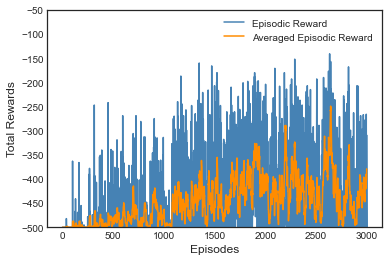

In [49]:
plt.style.use('seaborn-white')
window = 10
smoothed_rewards = [np.mean(scorestrain[i-window:i+1]) if i > window 
                    else np.mean(scorestrain[:i+1]) for i in range(len(scorestrain))]

plt.figure(figsize=(6,4))
plt.plot(scorestrain,color='steelblue',label='Episodic Reward')
plt.plot(smoothed_rewards,color='darkorange',label='Averaged Episodic Reward')
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')

plt.legend()
plt.legend.loc='best'
plt.ylim((-500,-50))
plt.show()

In [28]:
np.mean(scorestrain)

-446.53833333333336

In [29]:
np.std(scorestrain)

81.07707360215271

In [32]:
test = QLearningAgent(env, tq,'test')

Environment: <TimeLimit<AcrobotEnv<Acrobot-v1>>>
State space sizes: [(5, 5, 5, 5, 5, 5), (5, 5, 5, 5, 5, 5), (5, 5, 5, 5, 5, 5)]
Action space size: 3


In [33]:
def run(agent, env, num_episodes=1000, mode='test'):
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
    return scores

In [34]:
scorestest = run(test, env)

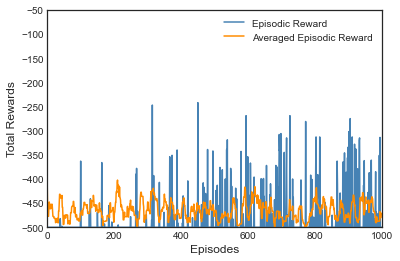

In [47]:
plt.style.use('seaborn-white')
window = 10
smoothed_rewards = [np.mean(scorestest[i-window:i+1]) if i > window 
                    else np.mean(scorestest[:i+1]) for i in range(len(scorestest))]

plt.figure(figsize=(6,4))
plt.plot(scorestrain,color='steelblue',label='Episodic Reward')
plt.plot(smoothed_rewards,color='darkorange',label='Averaged Episodic Reward')
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')

plt.legend()
plt.legend.loc='best'
plt.ylim((-500,-50))
plt.xlim((0,1000))
plt.show()

In [37]:
np.mean(scorestest)

-465.933

In [38]:
np.std(scorestest)

59.31379697001365